This file shows an example of leveraging the manually annotated labels to find the phantom objects in the ultrasound image for further automated analysis.

In [1]:
# two approaches to getting data
# use the manual segmenation and file name to grab elements, pull those elements by name from the phantom
# use center of mass
# transform the phantom center into the image using registration

import usqc.phantom
import usqc.data
import pickle
from glob import glob
import itk
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from usqc.qc import PSFSample
from usqc.manuscript import PROBE_PALETTE, PROBE_ORDERED, PROBE_PRETTY
# example anechoic_1-1 analysis
# get the 3 anechoic_1 replicates


#anechoic_1s = glob('../../../data/phantom_study-202201/annotated/butterfly-iq/vertical-1*points.pickle')
ph = usqc.phantom.Phantom()

In [2]:


#%debug
#%load_ext autoreload
#%autoreload 2
#import usqc.phantom
#phantom = usqc.phantom.Phantom()
#f = anechoic_1s[0]
# files is the files dict allowing us to get other files associated with this data point, e.g., the preprocessed US image
#files = usqc.data.get_files(f)
#img = itk.imread(files['preprocessed'])
#trans = itk.transformread(files['registered_transform'])[0]
#print(type(trans))
#print(phantom.elements_inside_transform(0, img, trans))

In [3]:
anechoic_1s = glob('../data/phantom_study-202201/annotated/sonivate/vertical-*points.pickle')
f = anechoic_1s[0]
f
img, component_img, feature_map, slice_ = ph.load_feature_map(f)

In [4]:
feature_map

{4: {'center': array([ 1.8350862 , 30.11518445]),
  'n': 4619.0,
  'label': 13,
  'phantom_label': 'contrast_3cm h',
  'phantom_element': <usqc.phantom.CircularTarget at 0x1fb8e140f40>},
 1: {'center': array([4.26707796, 5.8634529 ]),
  'n': 77.0,
  'label': 20,
  'phantom_label': 'nearfield 4',
  'phantom_element': <usqc.phantom.CircularTarget at 0x1fb8e126e60>},
 2: {'center': array([10.32100741, 10.63141365]),
  'n': 75.0,
  'label': 20,
  'phantom_label': 'vertical 0',
  'phantom_element': <usqc.phantom.CircularTarget at 0x1fbff6fda50>},
 3: {'center': array([10.33537807, 20.27700007]),
  'n': 81.0,
  'label': 20,
  'phantom_label': 'vertical 1',
  'phantom_element': <usqc.phantom.CircularTarget at 0x1fb8e125690>},
 5: {'center': array([10.36756834, 30.03603632]),
  'n': 110.0,
  'label': 20,
  'phantom_label': 'vertical 2',
  'phantom_element': <usqc.phantom.CircularTarget at 0x1fb8e125630>}}

In [5]:

my_f = ph.get_feature_by_phantom_label(feature_map , 'vertical 0')
my_f

(2,
 {'center': array([10.32100741, 10.63141365]),
  'n': 75.0,
  'label': 20,
  'phantom_label': 'vertical 0',
  'phantom_element': <usqc.phantom.CircularTarget at 0x1fbff6fda50>})

0.8233463726884783


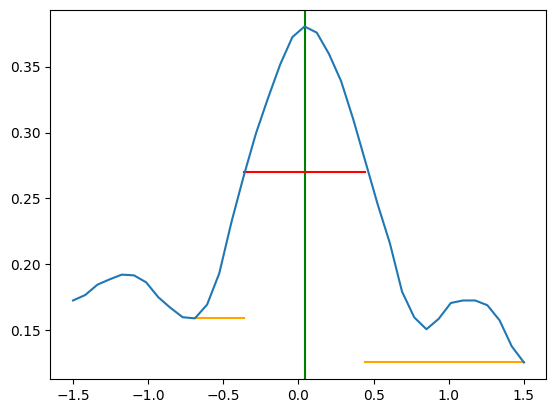

In [6]:
psf = PSFSample.calculate(my_f[1]['center'], np.pi, 1.5, img, prominence=0.07)

psf_mean = PSFSample.mean([psf, psf, psf])
psf_mean.plot()
print(psf_mean.width)

In [7]:
import pandas as pd
import pdb

file_types = []
labels = []

file_dict = { 
    'vertical' : [ 'vertical 0', 'vertical 1', 'vertical 2' ], 
    'elevational' : [ 'vertical 0', 'vertical 1', 'vertical 2' ],
    'axial_lateral' : [ 'ar1 b6' ] }

probes_master = [ 'clarius-l7hd', 'butterfly-iq', 'sonivate', 'sonoque-l5c', 'interson-spl01' ]
angles_master = [ np.pi / 2.0, np.pi ]

file_types = []
labels = []
probes = []
file_names = []
psfs = []
widths = []
angles = []
depths = []
master_depths = { 'vertical 0' : 10, 'vertical 1' : 20, 'vertical 2' : 30, 'ar1 b6' : 26 }

data_dir = '../data/phantom_study-202201'
for p in probes_master:
    for ft in list(file_dict.keys()):
        my_labels = file_dict[ft]
        files = glob(f'{data_dir}/annotated/{p}/{ft}*points.pickle')
        for f in files:
            print(f)
            img, component_img, feature_map, slice_ = ph.load_feature_map(f)
            for label in my_labels:
                for a in angles_master:
                    file_types.append(ft)
                    labels.append(label)
                    file_names.append(f)
                    probes.append(p)
                    angles.append(a)
                    depths.append(master_depths[label])
                    try:
                        my_f = ph.get_feature_by_phantom_label(feature_map , label)
                        
                        sample_width = 1.5
                        
                        # the psf will be extra-wide if the looking at the elevational profile
                        if a == np.pi and ft == 'elevational':
                            sample_width = 3
                        
                        psf = PSFSample.calculate(my_f[1]['center'], a, sample_width, img, prominence=0.1)
                        psfs.append(psf)
                        widths.append(psf.width)
                    except Exception as e:
                        # pdb.set_trace()
                        print(f'BAD: {f}')
                        psfs.append(None)
                        widths.append(None)                


../data/phantom_study-202201/annotated/clarius-l7hd\vertical-1-points.pickle
../data/phantom_study-202201/annotated/clarius-l7hd\vertical-2-points.pickle
../data/phantom_study-202201/annotated/clarius-l7hd\vertical-3-points.pickle
../data/phantom_study-202201/annotated/clarius-l7hd\elevational-1-points.pickle
../data/phantom_study-202201/annotated/clarius-l7hd\elevational-2-points.pickle
../data/phantom_study-202201/annotated/clarius-l7hd\elevational-3-points.pickle
../data/phantom_study-202201/annotated/clarius-l7hd\axial_lateral-1-points.pickle
../data/phantom_study-202201/annotated/clarius-l7hd\axial_lateral-2-points.pickle
../data/phantom_study-202201/annotated/clarius-l7hd\axial_lateral-3-points.pickle
../data/phantom_study-202201/annotated/butterfly-iq\vertical-1-points.pickle
../data/phantom_study-202201/annotated/butterfly-iq\vertical-2-points.pickle
../data/phantom_study-202201/annotated/butterfly-iq\vertical-3-points.pickle
../data/phantom_study-202201/annotated/butterfly-iq\

In [8]:
df = pd.DataFrame(data={'probe' : probes, 'file_type' : file_types, 'label' : labels, 'angle' : angles, 'file' : file_names, 'width' : widths, 'depth' : depths, 'psf' : psfs})


In [9]:
import seaborn as sb
df_aggr = df.groupby(['probe', 'file_type', 'label', 'angle', 'depth'])['width'].mean()
df_aggr = df_aggr.reset_index()
df_aggr

,probe,file_type,label,angle,depth,width
0,butterfly-iq,axial_lateral,ar1 b6,1.570796,26,0.711546
1,butterfly-iq,axial_lateral,ar1 b6,3.141593,26,0.724473
2,butterfly-iq,elevational,vertical 0,1.570796,10,0.608826
3,butterfly-iq,elevational,vertical 0,3.141593,10,2.253778
4,butterfly-iq,elevational,vertical 1,1.570796,20,0.599534
...,...,...,...,...,...,...
65,sonoque-l5c,vertical,vertical 0,3.141593,10,1.014024
66,sonoque-l5c,vertical,vertical 1,1.570796,20,0.569063
67,sonoque-l5c,vertical,vertical 1,3.141593,20,1.034613
68,sonoque-l5c,vertical,vertical 2,1.570796,30,0.563982


In [10]:
df.rename({ 'probe' : 'Probe' }, axis=1, inplace=True)
df.replace( PROBE_PRETTY, inplace=True)
df.Probe = pd.Categorical(df.Probe, categories=PROBE_ORDERED, ordered=True) 

In [11]:
df_aggr.rename({ 'probe' : 'Probe' }, axis=1, inplace=True)
df_aggr.replace( PROBE_PRETTY, inplace=True)
df_aggr.Probe = pd.Categorical(df_aggr.Probe, categories=PROBE_ORDERED, ordered=True) 

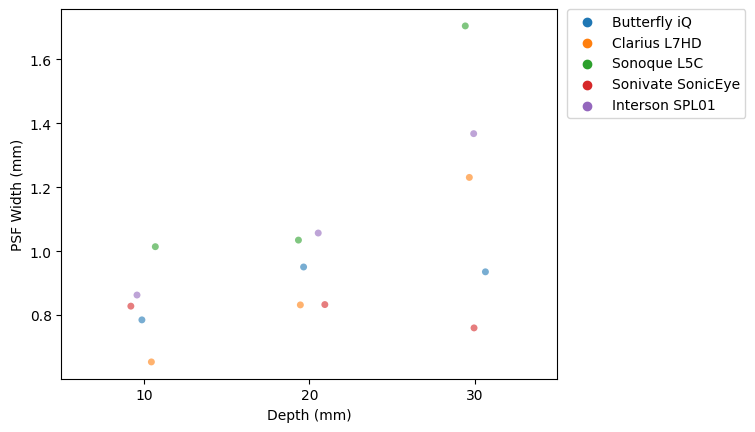

In [12]:
ax = sb.stripplot(data=df_aggr[(df_aggr['file_type'] == 'vertical') & (df_aggr['angle'] == np.pi)], y='width', x='depth', hue='Probe', alpha=0.6)
#ax.set_title('Horizontal PSF by Depth')
ax.set_xlabel('Depth (mm)')
ax.set_ylabel('PSF Width (mm)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('../data/phantom_study-202201/analysis/fig-psf-horizontal.pdf', bbox_inches='tight')

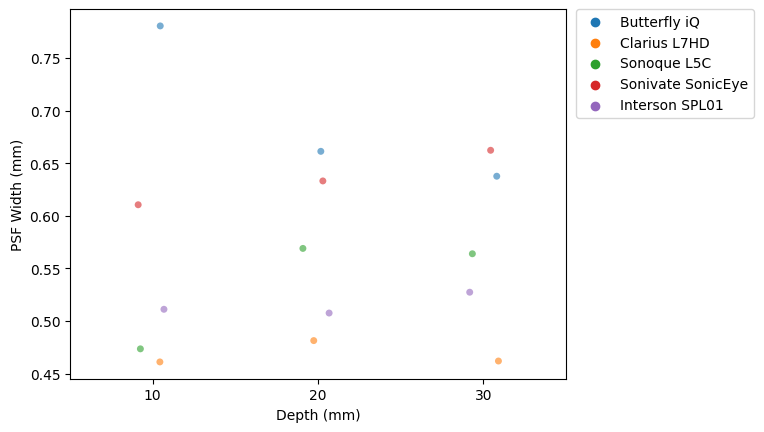

In [13]:
ax = sb.stripplot(data=df_aggr[(df_aggr['file_type'] == 'vertical') & (df_aggr['angle'] == np.pi/2)], y='width', x='depth', hue='Probe', alpha=0.6)
#ax.set_title('Vertical PSF by Depth')
ax.set_xlabel('Depth (mm)')
ax.set_ylabel('PSF Width (mm)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('../data/phantom_study-202201/analysis/fig-psf-vertical.pdf', bbox_inches='tight')

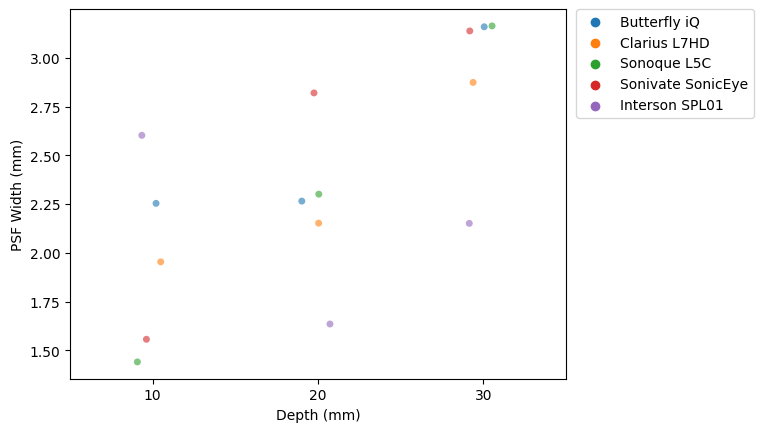

In [14]:
ax = sb.stripplot(data=df_aggr[(df_aggr['file_type'] == 'elevational') & (df_aggr['angle'] == np.pi)], y='width', x='depth', hue='Probe', alpha=0.6)
#ax.set_title('Elevational PSF by Depth')
ax.set_xlabel('Depth (mm)')
ax.set_ylabel('PSF Width (mm)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('../data/phantom_study-202201/analysis/fig-psf-elevational.pdf', bbox_inches='tight')

In [29]:
df_aggr.to_csv('../data/phantom_study-202201/analysis/psf values.csv')


In [17]:
def foo(psfs):
    return PSFSample.mean(psfs, coordinate='xs_centered_middle')

df_mean = df.groupby(['Probe', 'file_type', 'label', 'angle']).agg({ 'psf' : [foo] })
df_mean.reset_index(inplace=True)
df_mean

some peaks have a width of 0


,Probe,file_type,label,angle,psf
,,,,,foo
0,Butterfly iQ,axial_lateral,ar1 b6,1.570796,<usqc.qc.PSFSample object at 0x000001A16B6DAA40>
1,Butterfly iQ,axial_lateral,ar1 b6,3.141593,<usqc.qc.PSFSample object at 0x000001A16B6DAA10>
2,Butterfly iQ,axial_lateral,vertical 0,1.570796,NaN
3,Butterfly iQ,axial_lateral,vertical 0,3.141593,NaN
4,Butterfly iQ,axial_lateral,vertical 1,1.570796,NaN
...,...,...,...,...,...
115,Interson SPL01,vertical,vertical 0,3.141593,<usqc.qc.PSFSample object at 0x000001A16B700490>
116,Interson SPL01,vertical,vertical 1,1.570796,<usqc.qc.PSFSample object at 0x000001A16B7004F0>
117,Interson SPL01,vertical,vertical 1,3.141593,<usqc.qc.PSFSample object at 0x000001A16B700400>


In [18]:
def unroll(df):
    '''
    Takes the provided data frame and extracts the psf points into a long format data frame for plotting
    '''
    
    ans = { 'Probe' : [], 'label' : [], 'angle' : [], 'xs_centered' : [], 'ys' : [], 'file_type' : [], 'xs_centered_middle' : [] }
    
    for r in df.itertuples():
        idx, p, file_type, label, angle, psf = r
        
        if type(psf) != float:
            xs_centered = psf.xs_centered
            xs_centered_middle = psf.xs_centered_middle
            ys = psf.ys
            for i in range(len(xs_centered)):
                ans['Probe'].append(p)
                ans['file_type'].append(file_type)
                ans['label'].append(label)
                ans['angle'].append(angle)
                ans['xs_centered'].append(xs_centered[i])
                ans['ys'].append(ys[i])
                ans['xs_centered_middle'].append(xs_centered_middle[i])
    
    return pd.DataFrame(ans)


In [19]:
df_unroll = unroll(df_mean)
df_unroll

,Probe,label,angle,xs_centered,ys,file_type,xs_centered_middle
0,Butterfly iQ,ar1 b6,1.570796,-1.615385,0.250980,axial_lateral,-1.442308
1,Butterfly iQ,ar1 b6,1.570796,-1.557692,0.260131,axial_lateral,-1.384615
2,Butterfly iQ,ar1 b6,1.570796,-1.500000,0.260131,axial_lateral,-1.326923
3,Butterfly iQ,ar1 b6,1.570796,-1.442308,0.256209,axial_lateral,-1.269231
4,Butterfly iQ,ar1 b6,1.570796,-1.384615,0.257516,axial_lateral,-1.211538
...,...,...,...,...,...,...,...
6116,Interson SPL01,vertical 2,3.141593,1.386555,0.385621,vertical,1.361345
6117,Interson SPL01,vertical 2,3.141593,1.411765,0.384314,vertical,1.386555
6118,Interson SPL01,vertical 2,3.141593,1.436975,0.381699,vertical,1.411765
6119,Interson SPL01,vertical 2,3.141593,1.462185,0.379085,vertical,1.436975



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


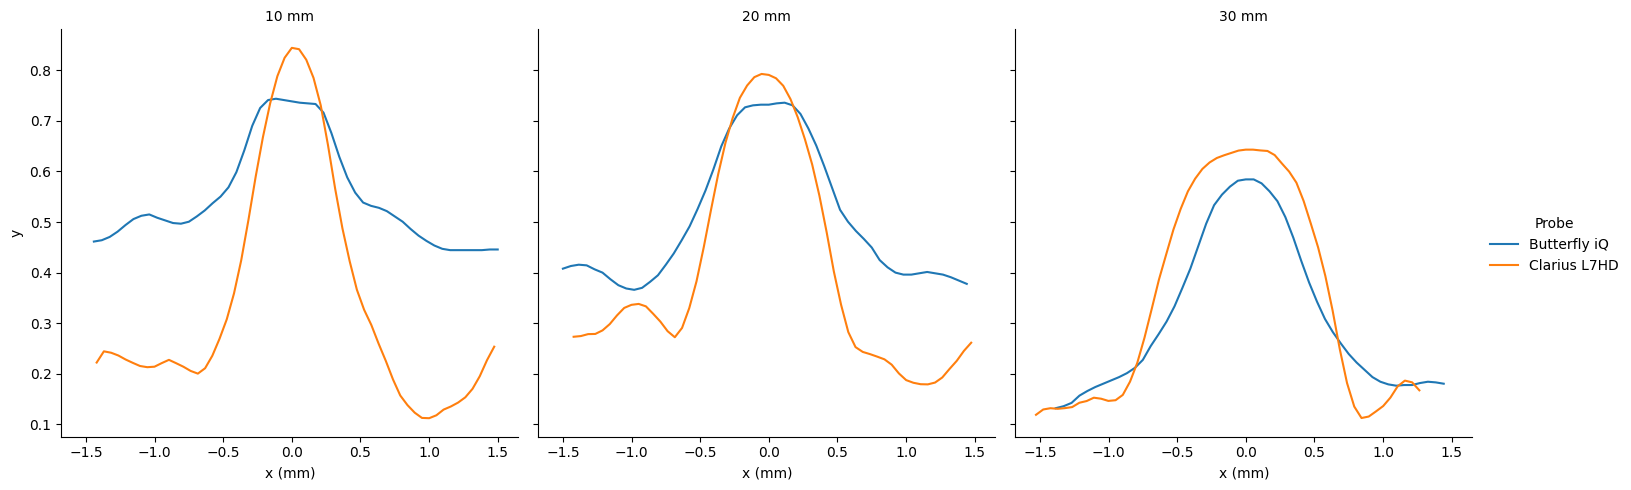

In [22]:
tmp = df_unroll[df_unroll['Probe'].isin(['Butterfly iQ', 'Clarius L7HD']) 
                & df_unroll['label'].isin(['vertical 0', 'vertical 1', 'vertical 2'])
                & (df_unroll['file_type'] == 'vertical')
                & (df_unroll['angle'] == np.pi)]

tmp.replace( { 'vertical 0' : '10 mm', 'vertical 1' : '20 mm', 'vertical 2' : '30 mm' }, inplace=True )
tmp.rename( { 'ys' : 'y', 'xs_centered_middle' : 'x (mm)' }, axis=1, inplace=True)

sb.relplot(tmp, x='x (mm)', y='y', hue='Probe', col='label', kind='line').set_titles('{col_name}')
plt.savefig('../data/phantom_study-202201/analysis/fig-psf-curve-comparison-horizontal.pdf', bbox_inches='tight')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


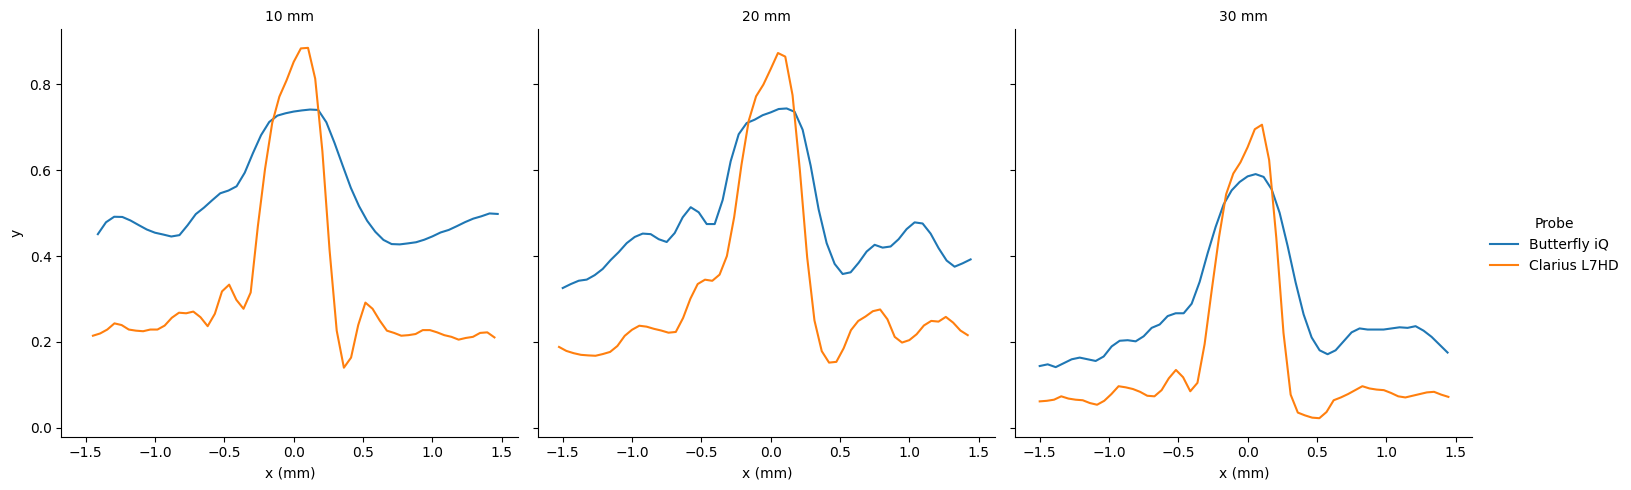

In [23]:
tmp = df_unroll[df_unroll['Probe'].isin(['Butterfly iQ', 'Clarius L7HD']) 
                & df_unroll['label'].isin(['vertical 0', 'vertical 1', 'vertical 2'])
                & (df_unroll['file_type'] == 'vertical')
                & (df_unroll['angle'] == np.pi/2)]


tmp.replace( { 'vertical 0' : '10 mm', 'vertical 1' : '20 mm', 'vertical 2' : '30 mm' }, inplace=True )
tmp.rename( { 'ys' : 'y', 'xs_centered_middle' : 'x (mm)' }, axis=1, inplace=True)

sb.relplot(tmp, x='x (mm)', y='y', hue='Probe', col='label', kind='line').set_titles('{col_name}')
plt.savefig('../data/phantom_study-202201/analysis/fig-psf-curve-comparison-vertical.pdf', bbox_inches='tight')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


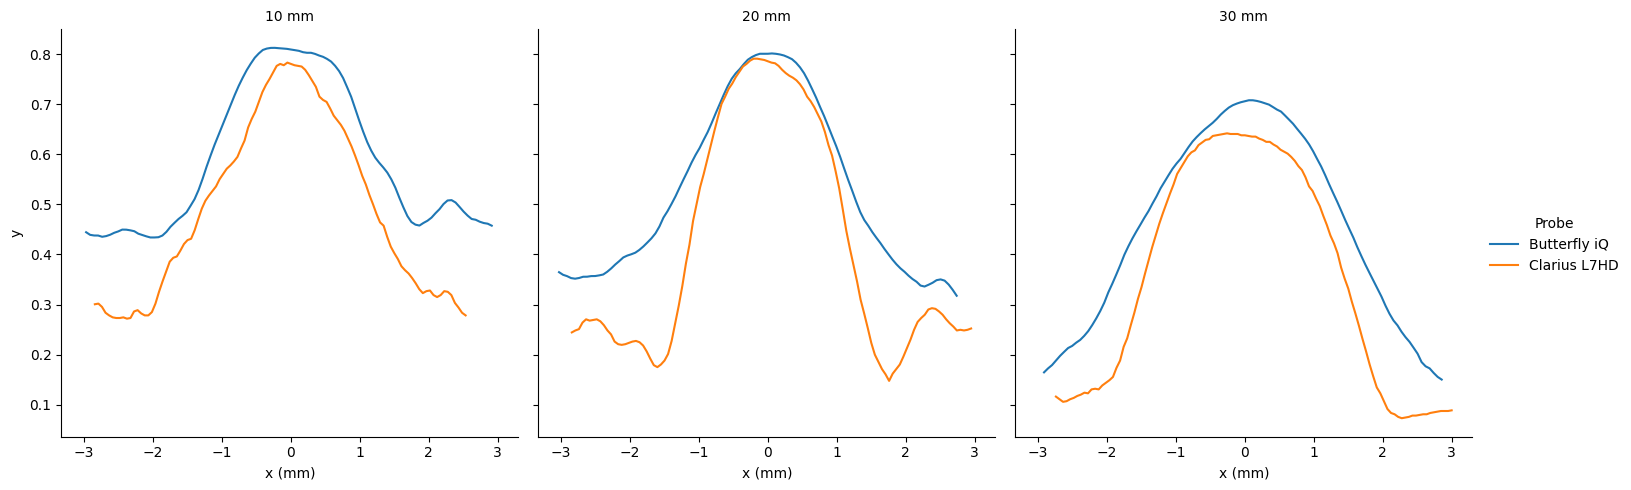

In [24]:
tmp = df_unroll[df_unroll['Probe'].isin(['Butterfly iQ', 'Clarius L7HD']) 
                & df_unroll['label'].isin(['vertical 0', 'vertical 1', 'vertical 2'])
                & (df_unroll['file_type'] == 'elevational')
                & (df_unroll['angle'] == np.pi)]


tmp.replace( { 'vertical 0' : '10 mm', 'vertical 1' : '20 mm', 'vertical 2' : '30 mm' }, inplace=True )
tmp.rename( { 'ys' : 'y', 'xs_centered_middle' : 'x (mm)' }, axis=1, inplace=True)

sb.relplot(tmp, x='x (mm)', y='y', hue='Probe', col='label', kind='line').set_titles('{col_name}')
plt.savefig('../data/phantom_study-202201/analysis/fig-psf-curve-comparison-elevational.pdf', bbox_inches='tight')

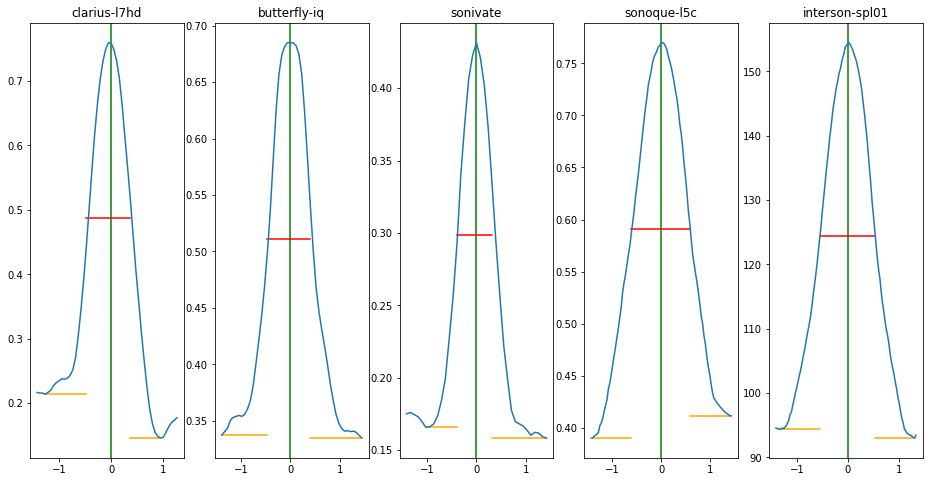

In [10]:
n = len(mean_psfs_dict)
fig, ax = plt.subplots(1, n, figsize=(16,8))
keys = list(mean_psfs_dict.keys())
for i in range(n):
    k = keys[i]
    mean_psfs_dict[k].plot(ax[i], 'xs_centered_middle', 'middle_peak')
    ax[i].set_title(k)

../data/phantom_study-202201/annotated/sonivate\vertical-1-points.pickle
../data/phantom_study-202201/annotated/sonivate\vertical-2-points.pickle
../data/phantom_study-202201/annotated/sonivate\vertical-3-points.pickle
[<__main__.PSFSample object at 0x000001D1AA2A2FA0>, <__main__.PSFSample object at 0x000001D1AA2A2CD0>, <__main__.PSFSample object at 0x000001D1AA2E6880>]
['../data/phantom_study-202201/annotated/sonivate\\vertical-1-points.pickle', '../data/phantom_study-202201/annotated/sonivate\\vertical-2-points.pickle', '../data/phantom_study-202201/annotated/sonivate\\vertical-3-points.pickle']


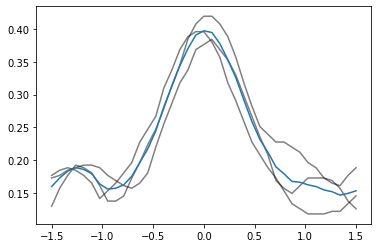

In [24]:
psfs = []
for f in anechoic_1s:
    img, component_img, feature_map, slice_ = ph.load_feature_map(f)
    my_f = ph.get_feature_by_phantom_label(feature_map , 'vertical 0')
    print(f)
    psf = PSFSample.calculate(my_f[1]['center'], np.pi, 1.5, img, prominence=0.1)
    psfs.append(psf)
print(psfs)
print(anechoic_1s)
psf_mean = PSFSample.mean(psfs, prominence=0.1)
for p in psfs:
    plt.plot(p.xs, p.ys, color='black', alpha=0.5)
plt.plot(psf_mean.xs, psf_mean.ys)

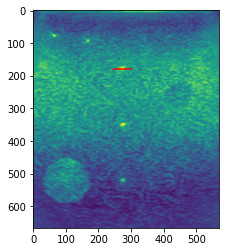

In [72]:
plt.imshow(img)
idx1 = img.TransformPhysicalPointToIndex(pts[0])
idx2 = img.TransformPhysicalPointToIndex(pts[-1])
plt.plot([idx1[0], idx2[0]], [idx1[1], idx2[1]], color='red')